# Introduction to `laplax`s FSP-Laplace regression tutorial

This tutorial follows one of the toy data experiments of [FSP-Laplace: Function-Space Priors for the Laplace Approximation in Bayesian Deep Learning](https://arxiv.org/abs/2407.13711) for regression and provides a quick overview of the FSP Laplace approximation in jax.
We regress on data that is modelled by:
$y = \sin(2\pi x) + \mathcal N(0, \sigma_n^2=0.1),$ on the intervals $[-1, -0.5] \cup [0.5, 1]$.

In [1]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import DataLoader, get_sinusoid_example, to_float64
from plotting import plot_regression_with_uncertainty, plot_sinusoid_task
from prior import *

import laplax
from laplax import util
from laplax.extra.fsp import *
from laplax.extra.fsp import lanczos_isqrt
from laplax.extra.fsp.fsp import compute_matrix_jacobian_product
from laplax.util.tree import to_dtype

jax.config.update("jax_enable_x64", True)


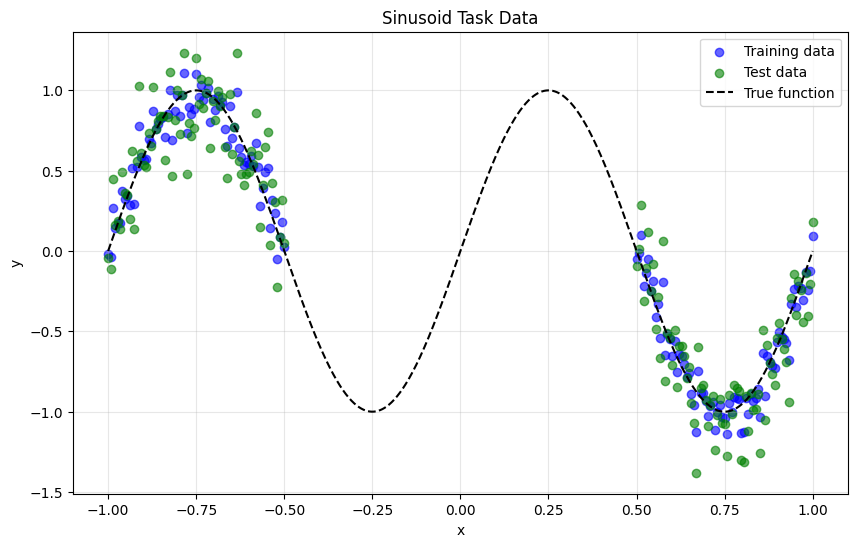

In [ ]:
batch_size = 150
key = jax.random.key(0)
X_train1 = jnp.linspace(-1, -0.5, 75).reshape(-1, 1)
X_train2 = jnp.linspace(0.5, 1, 75).reshape(-1, 1)
X_train = jnp.concatenate([X_train1, X_train2], axis=0)
y_train = jnp.reshape(jnp.sin(X_train * 2 * jnp.pi) + jax.random.normal(key, (150, 1)) * 0.1, (-1, 1))
X_test = X_train
y_test = jnp.reshape(jnp.sin(X_train * 2 * jnp.pi) + jax.random.normal(key, (150, 1)) * 0.2, (-1, 1))
train_loader = DataLoader(X_train, y_train, batch_size)
data = {"input": X_train, "target": y_train}

fig = plot_sinusoid_task(X_train, y_train, X_test, y_test)

## Training for the MAP and defining the GP prior

In [3]:
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_channels, hidden_channels, rngs=rngs)
        self.linear3 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear3(
            nnx.tanh(self.linear2(
                nnx.tanh(self.linear1(x)))
                )
            )
        return x
    

class MLP(nnx.Module):
    def __init__(self, model, param=None):
        self.model = model
        if param is not None:
            self.scale = nnx.Param(jnp.asarray(param))
        else:
            self.scale = nnx.Param(jnp.array(jnp.log(1 - jnp.exp(-0.1))))

    def __call__(self, x):
        return self.model(x)

    
model = Model(in_channels=1, hidden_channels=50, out_channels=1, rngs=nnx.Rngs(2))
model = to_float64(model)
model = MLP(model)

graph_def, params = nnx.split(model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]

prior_params = {
    # "per_ls": 2.947,
    # "per_p": 1.0,
    # "per_var": 6.608,
    # "matern52_ls": 143.478,
    "per_ls": 1.0,
    "per_p": 1.0,
    "per_var": 0.5,
    "matern52_ls": 4.0,
    "matern12_ls": 0.1,
    "matern12_var": 0.0,  # 0.25,
} 


def kernel_fn(xc):
    return gram(xc, prior_params, composite_kernel)

In [4]:
X_train.shape

(150, 1)

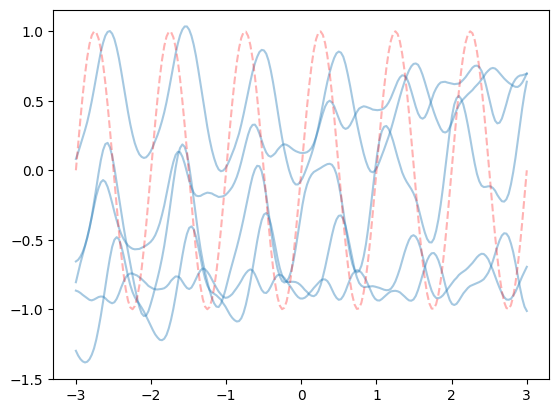

In [23]:
X_plot = jnp.linspace(-3, 3, 200)[:, None]

K = kernel_fn(X_plot)

K_sqrt = jax.scipy.linalg.sqrtm((K + K.T) / 2)

sample = K_sqrt @ jax.random.normal(jax.random.key(10), (K.shape[0], 5))

from matplotlib import pyplot as plt

plt.plot(X_plot, sample, color="C0", alpha=0.4)
plt.plot(X_plot, jnp.sin(X_plot * 2 * jnp.pi), color="red", linestyle="--", alpha=0.3)

In [12]:
@nnx.jit(static_argnames=['loss_fn'])
def train_step(model, data, x_context, loss_fn):
    def loss_function(model):
        graph_def, current_params = nnx.split(model)
        
        def wrapped_loss_fn(data, x_context, params):
            
            temp_model = nnx.merge(graph_def, params)
            return loss_fn(data, x_context, params, jax.nn.softplus(temp_model.scale.value))
        
        return wrapped_loss_fn(data, x_context, current_params)
    
    loss, grads = nnx.value_and_grad(loss_function)(model)
    return loss, grads

def train_model(model, n_epochs, lr=1e-3):
    optimizer = nnx.Optimizer(model, optax.adam(lr))
    graph_def, _ = nnx.split(model)
    
    def model_fn(input, params):
        return nnx.call((graph_def, params))(input)[0]
    
    loss_fn = create_fsp_objective(model_fn, X_train.shape[0], jnp.zeros((100, 1)), kernel_fn)  # noqa: F405
    
    for epoch in range(n_epochs):
        for x_tr, y_tr in train_loader:
            data = {"input": x_tr, "target": y_tr}
            x_context = jnp.linspace(-2, 2, 100).reshape(-1, 1)
            
            loss, grads = train_step(model, data, x_context, loss_fn)
            optimizer.update(grads)
        
        if epoch % 100 == 0:
            print(f"[epoch {epoch}]: loss: {loss:.4f} Scale: {jax.nn.softplus(model.scale.value):.4f}")
            
    print(f"Final loss: {loss:.4f}")
    return model

model = train_model(model, n_epochs=1000)

[epoch 0]: loss: -53.8376 Scale: 0.1238
[epoch 100]: loss: -70.9552 Scale: 0.1221
[epoch 200]: loss: 14.2676 Scale: 0.1185
[epoch 300]: loss: -92.9878 Scale: 0.1175
[epoch 400]: loss: -69.3769 Scale: 0.1161
[epoch 500]: loss: -130.8386 Scale: 0.1131
[epoch 600]: loss: -104.5331 Scale: 0.1131
[epoch 700]: loss: -137.4511 Scale: 0.1132
[epoch 800]: loss: -74.8319 Scale: 0.1136
[epoch 900]: loss: -91.5446 Scale: 0.1120
[epoch 1000]: loss: -108.4962 Scale: 0.1115
[epoch 1100]: loss: -104.4190 Scale: 0.1101
[epoch 1200]: loss: -142.1343 Scale: 0.1105
[epoch 1300]: loss: -117.1401 Scale: 0.1096
[epoch 1400]: loss: -103.2370 Scale: 0.1099
[epoch 1500]: loss: -93.9406 Scale: 0.1080
[epoch 1600]: loss: -57.7502 Scale: 0.1068
[epoch 1700]: loss: -112.4731 Scale: 0.1066
[epoch 1800]: loss: -85.8600 Scale: 0.1062
[epoch 1900]: loss: -38.7764 Scale: 0.1059
[epoch 2000]: loss: -85.6347 Scale: 0.1047
[epoch 2100]: loss: -72.7504 Scale: 0.1043
[epoch 2200]: loss: -152.5358 Scale: 0.1051
[epoch 2300]: 

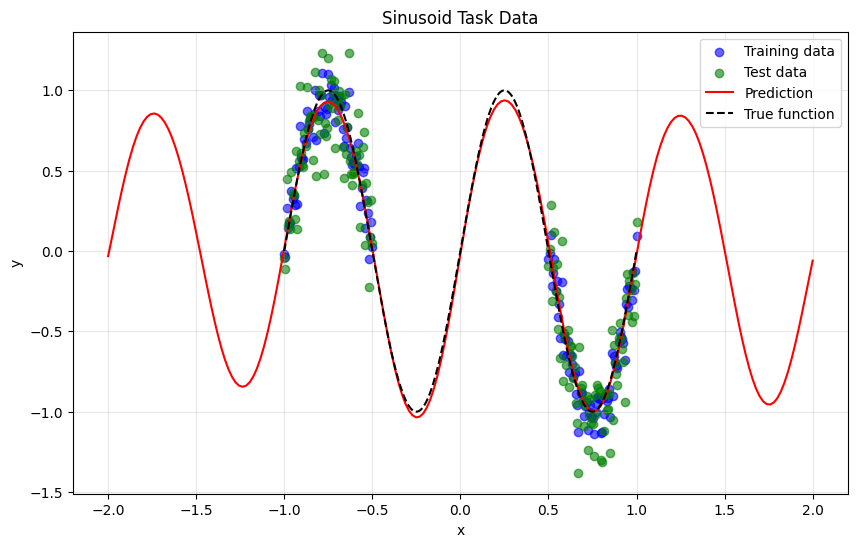

In [16]:
X_pred = jnp.linspace(-2., 2., 200).reshape(200, 1)
y_pred = jax.vmap(model)(X_pred)

_ = plot_sinusoid_task(X_train, y_train, X_test, y_test, X_pred, y_pred)

In [17]:

graph_def, params = nnx.split(model.model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]

context_points = select_context_points(1000, "grid", [3.0], [-3.0], X_train.shape, key=jax.random.key(0))
prob_predictive = fsp_laplace(model_fn, params, data, kernel_fn, context_points)

eta: 39.34647248509611 - sq_norm = 1.0
eta: 114.003857029426 - sq_norm = 1.044946878740863
eta: 20.054544975339674 - sq_norm = 1.7742068893301073
eta: 11.865085762499216 - sq_norm = 1.2508204841742028
eta: 12.469940192765304 - sq_norm = 3.314536668760108
eta: 9.401797739218138 - sq_norm = 2.325167505891325
eta: 26.526169778094328 - sq_norm = 3.270809231415351
eta: 59.59428699011611 - sq_norm = 9.957757627848258
eta: 1.0793931916179547 - sq_norm = 0.6821337039814451
eta: 2.767746814478053 - sq_norm = 0.9608735842826958
eta: 0.31905072412188207 - sq_norm = 0.5064818714453068
eta: 0.42302129110130215 - sq_norm = 0.6724126238920027
eta: 0.0546552117460928 - sq_norm = 0.1455965614166093
eta: 0.03420303183531185 - sq_norm = 0.16662926915340343
eta: 0.03470468964034556 - sq_norm = 0.12188649202366687
eta: 0.233209543547464 - sq_norm = 0.1423614458850436
eta: 0.005422117222719876 - sq_norm = 0.04403553484581148
eta: 0.005889125114733673 - sq_norm = 0.03000052314991561
eta: 0.001334527034911706

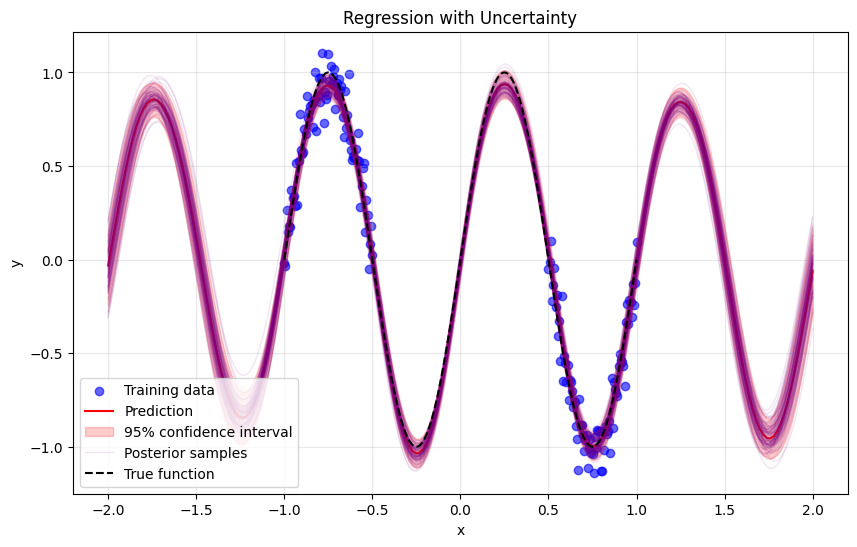

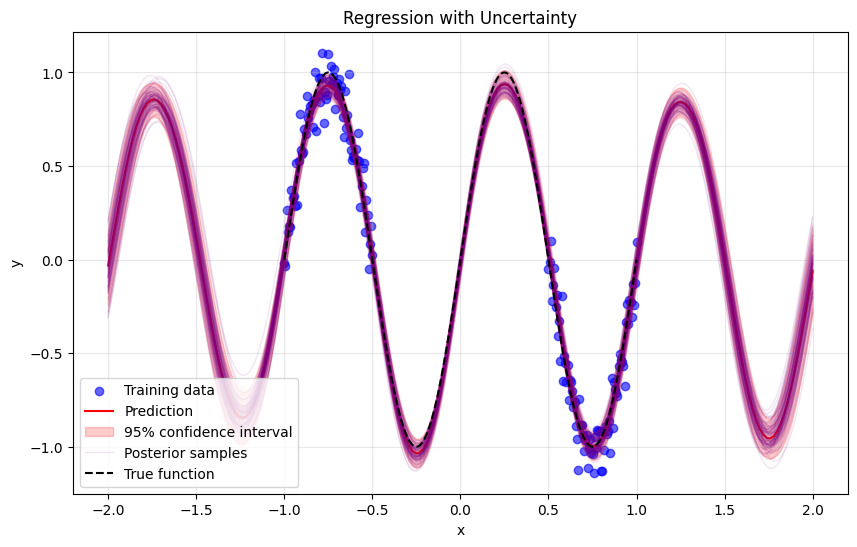

In [20]:
X_pred = jnp.linspace(-2, 2, 200, dtype=jnp.float64).reshape(-1, 1)

pred = jax.vmap(prob_predictive)(X_pred)
plot_regression_with_uncertainty(
        X_train=data["input"],
        y_train=data["target"],
        X_pred=X_pred,
        y_pred=pred["pred_mean"][:, 0],
        y_std=jnp.sqrt(pred["pred_var"][:, 0]),
        y_samples=pred["samples"],
    )
